#  Show Image

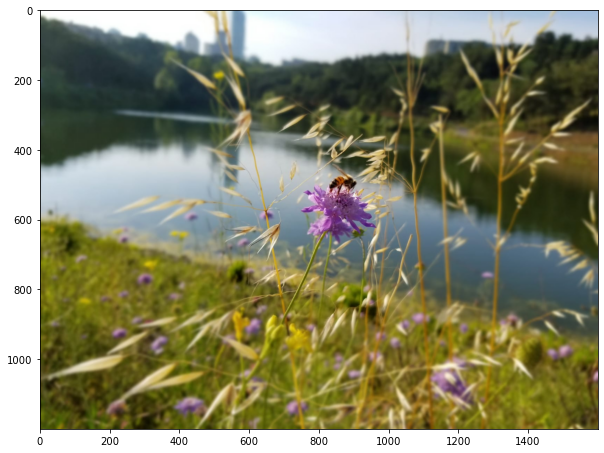

In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
img = cv2.imread('.\\data\\ITU_Golet_Ari.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


# Ground Truth

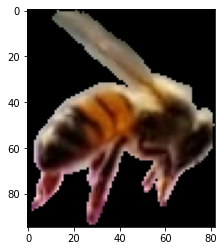

In [15]:
# From .\data\via_project_18Jun2020_15h19m_json.json
poly_outline = {
    "all_points_x": [825, 832, 836, 838, 839, 839, 849, 853, 853, 852, 853, 854, 852, 852, 852, 853, 856, 858, 859, 860, 863, 864, 865, 867, 868, 870, 872, 874, 879, 881, 882, 877, 876, 877, 879, 884, 884, 882, 883, 884, 887, 889, 890, 894, 900, 903, 905, 905, 906, 905, 903, 901, 899, 895, 895, 890, 888, 884, 881, 879, 872, 868, 863, 858, 852, 846, 842, 838, 837, 842, 846, 850, 853, 857, 860, 864, 867, 870, 869, 865, 862, 857, 852, 849, 846, 842, 839, 836, 834, 831, 829, 829, 829, 830, 832, 832, 830, 830, 829, 830],
    "all_points_y": [528, 524, 520, 517, 513, 512, 509, 507, 511, 514, 516, 518, 526, 531, 534, 535, 528, 523, 520, 516, 510, 505, 503, 500, 499, 503, 504, 505, 505, 506, 506, 514, 516, 519, 515, 509, 513, 516, 523, 525, 518, 515, 512, 509, 506, 502, 499, 496, 491, 488, 485, 485, 486, 481, 475, 474, 473, 471, 470, 470, 461, 457, 454, 450, 445, 441, 442, 441, 445, 449, 453, 456, 460, 463, 465, 469, 471, 474, 476, 475, 474, 474, 476, 478, 479, 481, 484, 488, 491, 494, 498, 502, 506, 509, 510, 513, 517, 521, 523, 524]
}

# Defines the polygone points that surrounds the bee.
pts = np.array(list([x, y] for x, y in zip(poly_outline["all_points_x"], poly_outline["all_points_y"])))

## (1) Crop the bounding rect
rect = cv2.boundingRect(pts)
x,y,w,h = rect
croped = img[y:y+h, x:x+w].copy()

## (2) make mask
pts = pts - pts.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst = cv2.bitwise_and(croped, croped, mask=mask)
plt.imshow(dst)

# Segmenting based on Color

* I first convert the image into HSV and threshold Saturation. This nicely segments the bee from the background.
* I then threshold from the Hue to segment the flower below the bee.
* I then combine these two thresholds to have the bee isolated.
* Then I dilate the image using `cv2.dilate` which makes the bee borders more pronounced.
* After that I create the countors and enumarate the closed loop countors.
* The 40th one is the bee! 
* After that I calculate the IoU using the 40th countour.

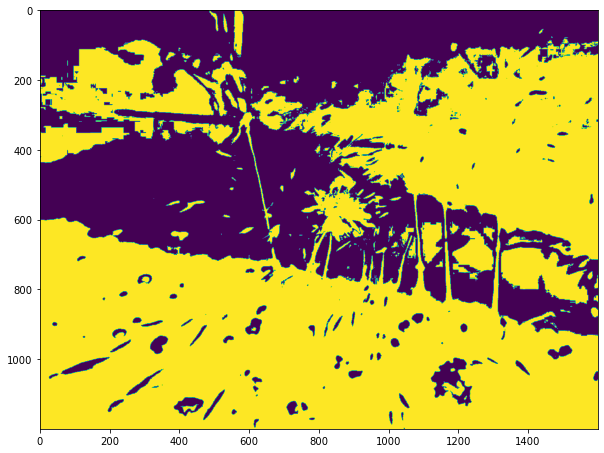

In [16]:
f1 = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1]/256 > 0.3
plt.figure(figsize=(10,10))
plt.imshow(f1)

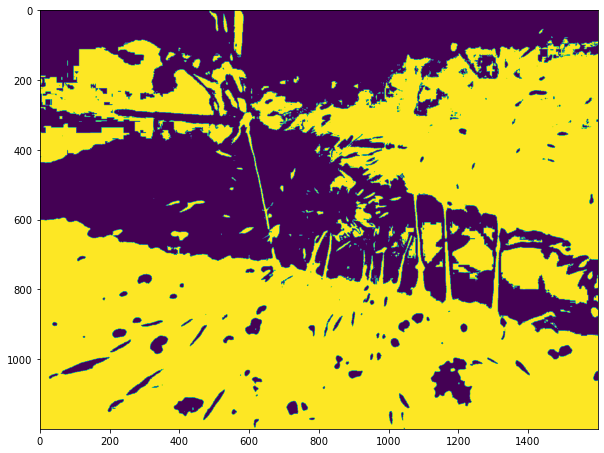

In [17]:
f2 = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,0]/256 < 0.55
plt.figure(figsize=(10,10))
plt.imshow(f1&f2)

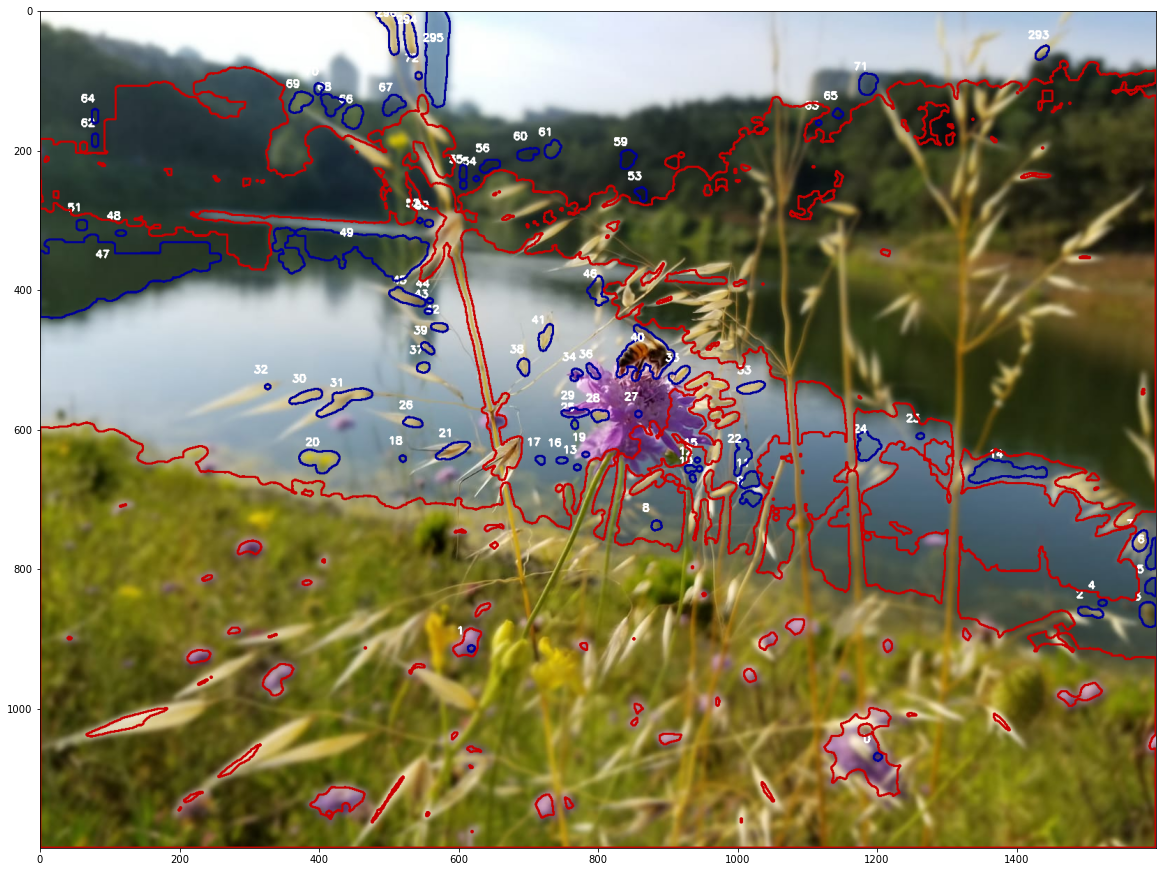

In [18]:
src = img.copy()
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
dilated = cv2.dilate(np.array(f1&f2, dtype=np.uint8), kernel)
edges = cv2.Canny(dilated,0,1,True)
contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
hierarchy = hierarchy[0]
for i, c in enumerate(contours):
    # Is it a closed loop?
    if hierarchy[i][2] < 0 and hierarchy[i][3] < 0:

        if cv2.contourArea(c) <= 0:
            continue

        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        # draw the contour and center of the shape on the image
        cv2.drawContours(src, contours, i, (0, 0, 150), 2)
        cv2.putText(src, str(i), (cX - 20, cY - 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)




    else:
        cv2.drawContours(src, contours, i, (200, 0, 0), 2)
#write to the same directory
plt.figure(figsize=(20, 20))
plt.imshow(src)

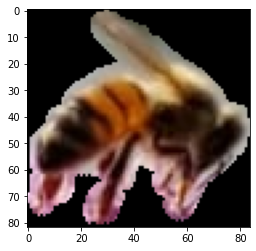

In [19]:
pts = contours[40] #40th is the bee!

## (1) Crop the bounding rect
rect2 = cv2.boundingRect(pts)
x2,y2,w2,h2 = rect2
croped = img[y2:y2+h2, x2:x2+w2].copy()

## (2) make mask
pts = pts - pts.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

## (3) do bit-op
dst2 = cv2.bitwise_and(croped, croped, mask=mask)
plt.imshow(dst2)

In [20]:
# cropped_img = img[min(y, y2): min(y, y2)+max(h, h2), min(x, x2): min(x, x2)+max(w, w2)]
cropped_img = img.copy()

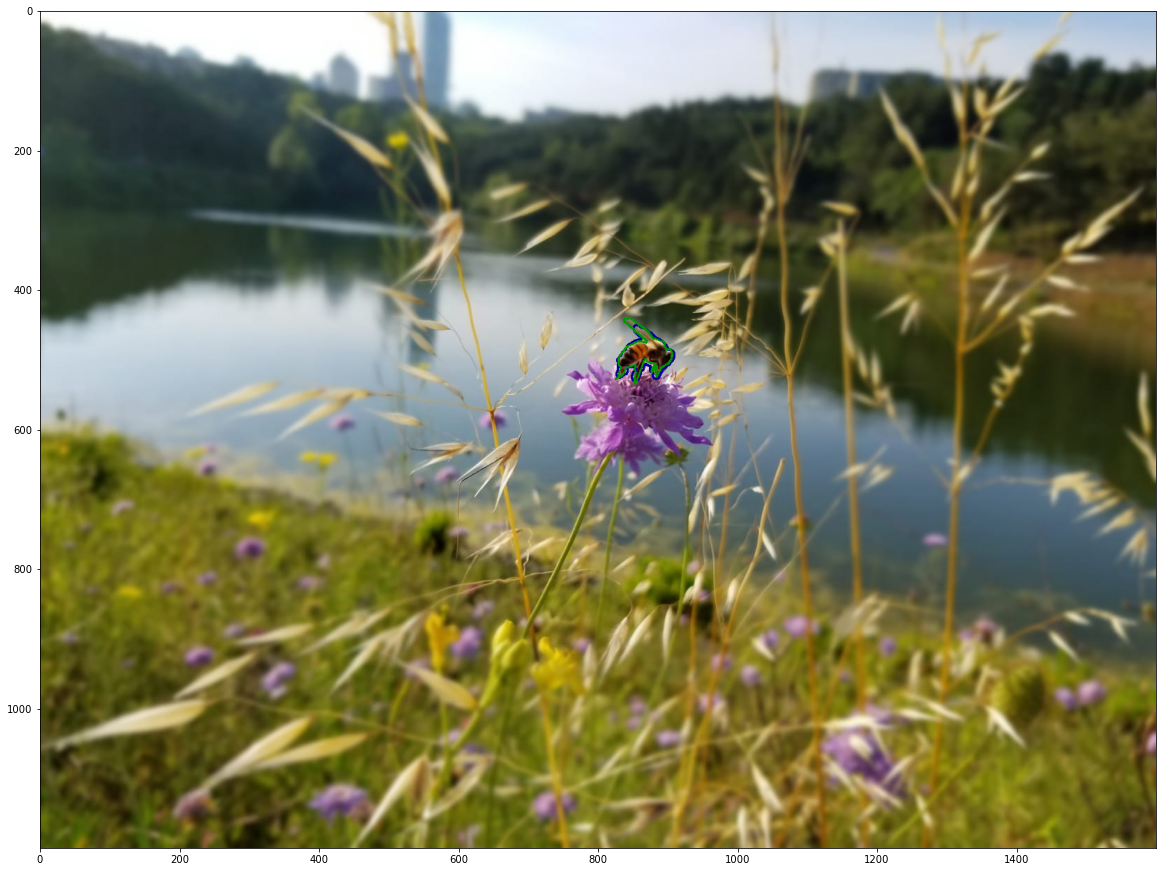

In [21]:
cv2.drawContours(cropped_img, contours, 40, (0, 0, 150), 2)

pts = np.array(list([x, y] for x, y in zip(poly_outline["all_points_x"], poly_outline["all_points_y"])))

cv2.drawContours(cropped_img, [pts], 0, (0, 150, 0), 2)
plt.figure(figsize=(20, 20))
plt.imshow(cropped_img)

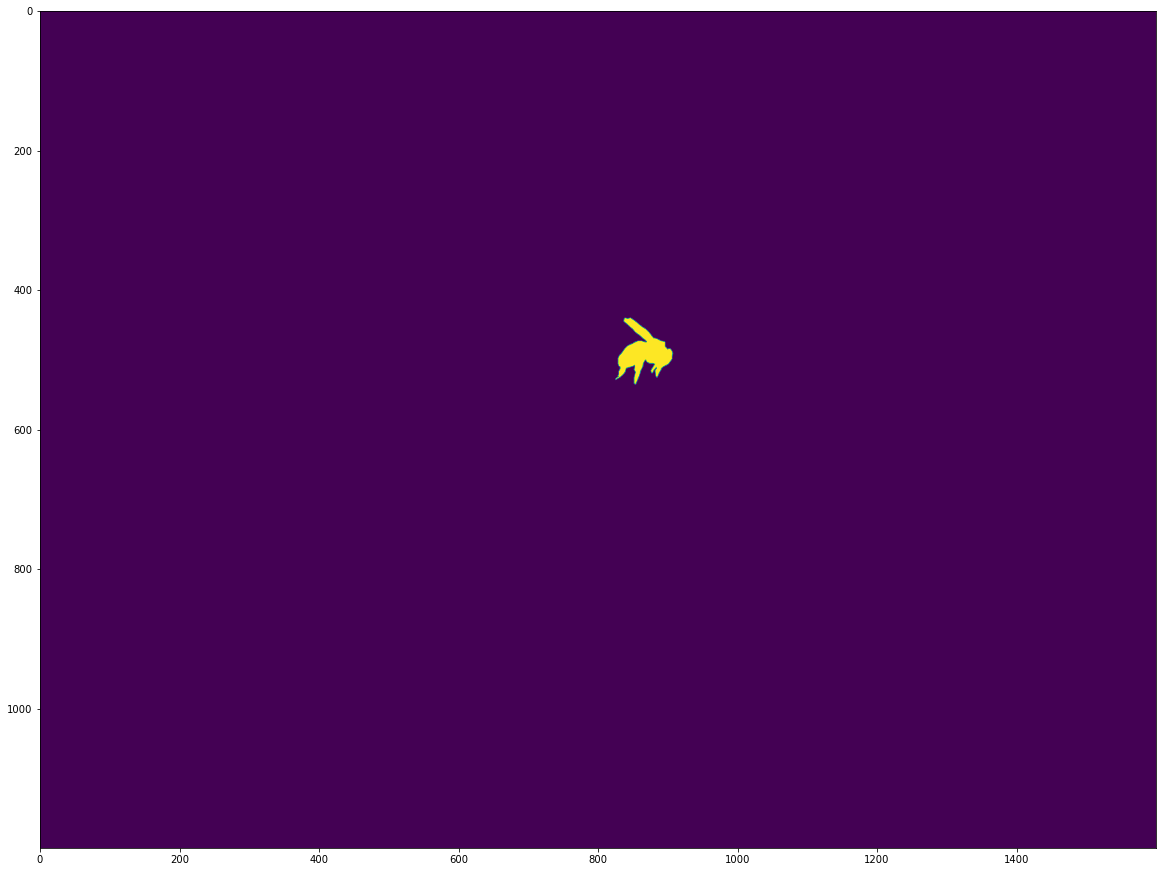

In [22]:
# Ground truth
pts = np.array(list([x, y] for x, y in zip(poly_outline["all_points_x"], poly_outline["all_points_y"])))
mask = np.zeros(img.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
plt.figure(figsize=(20,20))
plt.imshow(mask)

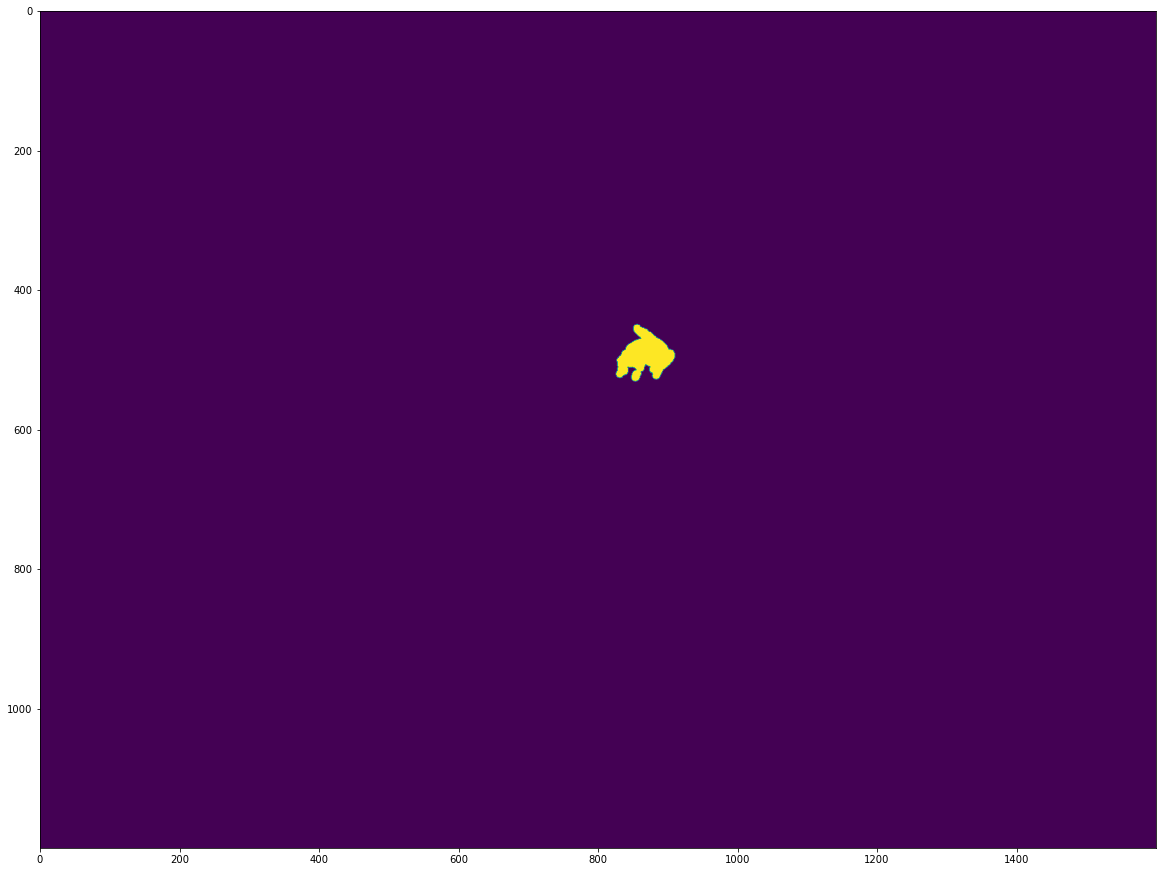

In [23]:
# Borders I found
pts = contours[40]
mask2 = np.zeros(img.shape[:2], np.uint8)
cv2.drawContours(mask2, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
plt.figure(figsize=(20,20))
plt.imshow(mask2)

In [24]:
intersection = np.logical_and(mask, mask2)
union = np.logical_or(mask, mask2)
iou_score = np.sum(intersection) / np.sum(union)
iou_score

0.7855146716348393